Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/73257 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.66FYCD_3.1.0/svhn_cropped-train.tfrecord*...:   0%…

Generating test examples...:   0%|          | 0/26032 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.66FYCD_3.1.0/svhn_cropped-test.tfrecord*...:   0%|…

Generating extra examples...:   0%|          | 0/531131 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.66FYCD_3.1.0/svhn_cropped-extra.tfrecord*...:   0%…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.1.0. Subsequent calls will reuse this data.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.1468 - loss: 2.8325 - val_accuracy: 0.3677 - val_loss: 1.9919 - learning_rate: 0.0010
Epoch 2/10
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3040 - loss: 2.0881 - val_accuracy: 0.4558 - val_loss: 1.7227 - learning_rate: 0.0010
Epoch 3/10
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.3720 - loss: 1.9194 - val_accuracy: 0.5055 - val_loss: 1.6194 - learning_rate: 0.0010
Epoch 4/10
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.4021 - loss: 1.8523 - val_accuracy: 0.5273 - val_loss: 1.5550 - learning_rate: 0.0010
Epoch 5/10
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.4230 - loss: 1.8144 - val_accuracy: 0.5438 - val_loss: 1.5341 - learning_rate: 0.0010
Epoch 6/10
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.4377 - loss: 1.7839 - val_accuracy: 0.5474 - val_loss: 1.4977 - learning_rate: 0.0010
Epoch 7/10
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accura

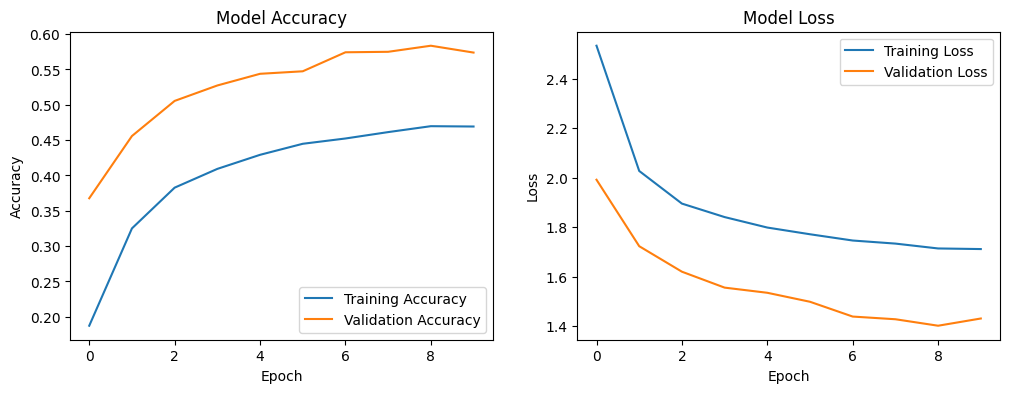

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler

# Load SVHN Dataset
dataset, info = tfds.load("svhn_cropped", split=["train", "test"], as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset

def dataset_to_numpy(dataset):
    images, labels = [], []
    for img, label in tfds.as_numpy(dataset):
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

# Normalize Data
mean = np.mean(X_train, axis=(0,1,2))
std = np.std(X_train, axis=(0,1,2))
X_train = (X_train - mean) / (std + 1e-7)
X_test = (X_test - mean) / (std + 1e-7)

# Flatten images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-Hot Encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Split data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1
    return lr

# Build Flexible Feedforward Neural Network
def build_model(hidden_layers=[128, 64], activation='relu', optimizer='adam', weight_decay=0):
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation=activation, input_shape=(X_train.shape[1],),
                    kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation,
                        kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameters
hidden_layers = [128, 64, 32]
activation_function = 'relu'
optimizer_choice = tf.keras.optimizers.Adam(learning_rate=1e-3)
weight_decay_value = 0.0005
batch_size = 64
epochs = 10

# Train Model
model = build_model(hidden_layers=hidden_layers, activation=activation_function, optimizer=optimizer_choice, weight_decay=weight_decay_value)
lr_callback = LearningRateScheduler(lr_scheduler)
history = model.fit(
    X_train_split, y_train_split,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[lr_callback],
    verbose=1
)

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_acc:.4f}')

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()
